# LR示例

以下示例仅用于说明LR的工作流程，目前仅支持单机测试。

PSI

In [1]:
import pandas as pd
import os
from PSI import PSICompany, PSIPartner

project_dir = os.path.dirname(os.path.abspath(''))
data_dir = os.path.join(project_dir, 'Datasets', 'data', 'data')
host_data = pd.read_csv(os.path.join(data_dir, 'breast_hetero_host.csv'))
guest_data = pd.read_csv(os.path.join(data_dir, 'breast_hetero_guest.csv'))

company_key, company_features = host_data['id'], host_data.drop(columns=['id'])
partner_key, partner_features = guest_data['id'], guest_data.drop(columns=['id'])
company_key = company_key.astype(str)
partner_key = partner_key.astype(str)
company = PSICompany(company_key, company_features)
partner = PSIPartner(partner_key, partner_features)

U_c, company_pk = company.exchange()
E_c, U_p, partner_pk = partner.exchange(U_c, company_pk)
L, R_cI = company.compute_intersection(E_c, U_p, partner_pk)
R_pI = partner.output_shares(L)
company_share = R_cI[0]
partner_share = R_pI[0]

[2025-08-08 16:38:52.248] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
Computing masked company cipher
Computing masked partner cipher
Computing company shares
Computing partner shares


此时share是`np.ndarray`类型。下面将其放入秘密共享设备spu中。
目前我暂时还没有找到由share直接构造`SPUObject`的方法。可以暂时使用这个方法：

In [2]:
from common import MPCInitializer
import secretflow as sf
import numpy as np
import jax.numpy as jnp
mpc_init = MPCInitializer()
company, partner, coordinator, spu = mpc_init.company, mpc_init.partner, mpc_init.coordinator, mpc_init.spu
# 假设y由company持有
label_holder = company

def share2spu(X1 : np.ndarray, X2 : np.ndarray):
    """
    X1：由Company持有的share
    X2：由Partner持有的share
    """    
    X1, X2 = jnp.array(X1,dtype=jnp.float32), jnp.array(X2,dtype=jnp.float32)
    # 将X1，X2分别移动到spu
    X1 = sf.to(company, X1).to(spu)
    X2 = sf.to(partner, X2).to(spu)
    # 再在spu内部相加，得到秘密共享的变量X
    def add(X1, X2):
        """
        在SPU中执行加法操作
        """
        return X1 + X2
    return spu(add)(X1, X2)

/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-08 16:45:01,194	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-08 16:45:01,292	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatib

(pyu_fn pid=21128) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(pyu_fn pid=21128) [2025-08-08 16:45:06.292] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(pyu_fn pid=21128) [2025-08-08 16:45:06.298] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=21128) [2025-08-08 16:45:06.299] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime(device_id=None, party=coordinator) pid=21129) 2025-08-08 16:45:07.752 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 15
(pyu_fn pid=21130) [2025-08-08 16:45:07.678] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=21130) [2025-08-08 16:45:07.679] [warning] [openssl_factory.cc:83] Yacl has been configured to 

划分训练集和测试集

In [3]:
from sklearn.model_selection import train_test_split


train_1, test_1, train_2, test_2 = train_test_split(
    company_share, partner_share)
train_X1, train_y1 = train_1[:, :-1], train_1[:, -1].reshape(-1,1)
train_X2, train_y2 = train_2[:, :-1], train_2[:, -1].reshape(-1,1)
test_X1, test_y1 = test_1[:, :-1], test_1[:, -1].reshape(-1,1)
test_X2, test_y2 = test_2[:, :-1], test_2[:, -1].reshape(-1,1)

test_X = share2spu(test_X1, test_X2)
# 目前的模型在推理状态下，预测值按公开处理，因此测试集的y也公开
test_y = test_y1 + test_y2

训练集划分batch以实现批量训练

In [4]:
num_samples, num_features = train_X1.shape  # train_X1和train_X2的样本数相同

batch_size = 1024
Xs = []
ys = []
for j in range(0,num_samples,batch_size):
    batch = min(batch_size,num_samples - j)
    X_batch = share2spu(train_X1[j:j+batch], train_X2[j:j+batch])
    y_batch = share2spu(train_y1[j:j+batch], train_y2[j:j+batch])
    Xs.append(X_batch)
    ys.append(y_batch)

训练指定的轮次

In [5]:
from LR import SSLR

model = SSLR(num_features)
model.fit(Xs, ys, n_iter=10)

Epoch 1


8it [00:00, 16.95it/s]


Epoch 2


8it [00:00, 20.71it/s]


Epoch 3


8it [00:00, 20.78it/s]


Epoch 4


8it [00:00, 20.54it/s]


Epoch 5


8it [00:00, 19.62it/s]


Epoch 6


8it [00:00, 20.38it/s]


Epoch 7


8it [00:00, 20.72it/s]


Epoch 8


8it [00:00, 20.68it/s]


Epoch 9


8it [00:00, 19.80it/s]


Epoch 10


8it [00:00, 20.51it/s]


或手动训练，绘制正确率曲线

Epoch 1


0it [00:00, ?it/s]

8it [00:00, 21.25it/s]


Iteration 1, Accuracy: 0.9996
Epoch 2


8it [00:00, 21.24it/s]


Epoch 3


8it [00:00, 20.33it/s]


Epoch 4


8it [00:00, 20.59it/s]


Epoch 5


8it [00:00, 20.92it/s]


Epoch 6


8it [00:00, 21.51it/s]


Epoch 7


8it [00:00, 21.87it/s]


Epoch 8


8it [00:00, 22.19it/s]


Epoch 9


8it [00:00, 21.33it/s]


Epoch 10


8it [00:00, 21.97it/s]


Epoch 11


8it [00:00, 21.94it/s]


Epoch 12


8it [00:00, 22.29it/s]


Epoch 13


8it [00:00, 22.36it/s]


Epoch 14


8it [00:00, 22.19it/s]


Epoch 15


8it [00:00, 21.87it/s]


Epoch 16


8it [00:00, 21.92it/s]


Epoch 17


8it [00:00, 21.49it/s]


Epoch 18


8it [00:00, 22.21it/s]


Epoch 19


8it [00:00, 21.45it/s]


Epoch 20


8it [00:00, 21.65it/s]


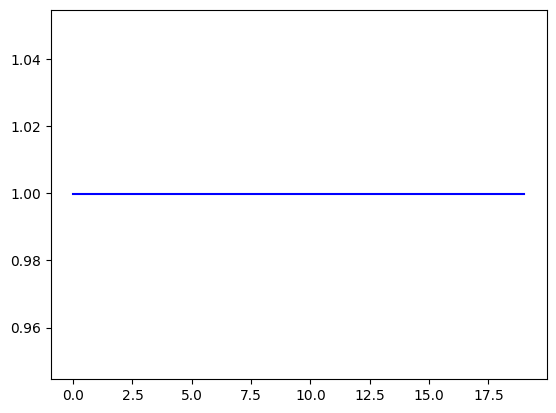

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

model = SSLR(num_features)
n_iter = 20
accs = []
max_acc = 0
for t in range(1,n_iter + 1):
    print(f"Epoch {t}")
    for X,y in tqdm(zip(Xs, ys)):
        y_pred = model.forward(X)
        model.backward(X, y, y_pred, 0.1 / t)

    y_pred = model.predict(test_X)
    Accuracy = accuracy_score(test_y, y_pred)
    if Accuracy > max_acc:
        max_acc = Accuracy
        print(f"Iteration {t}, Accuracy: {Accuracy:.4f}")
    accs.append(Accuracy)

plt.plot(accs,label = "SSLR",color = "blue")